# Tutorial: Profiling a PyTorch Model with Metinor

In this tutorial, we will use Metinor to profile a PyTorch model. Profiling a model is important to understand the performance of the model and to identify bottlenecks. Metinor provides a simple API to profile a model and a set of tools to analyze and plot the results.

In [1]:
# Suppress warnings (to make the output cleaner in this notebook)
import warnings

warnings.filterwarnings("ignore")

## Create a model

The profiler in Metinor supports subclasses of `nn.Module`. In this tutorial, we will use a pre-trained ResNet-18 from `torchvision`.

In [2]:
from torchvision.models import resnet18, ResNet18_Weights

# Create the model to profile
model = resnet18(weights=ResNet18_Weights.DEFAULT)
input_shape = (3, 224, 224)

## Import the profiler

Next, we will import the profiler from the `metinor.profiler` package. This is available as `metinor.profiler.Profiler` class and several `metinor.functional.profiler.profile_*` functions. We will profile both the model types using the profiler class and the functions.

### Profiling a model using the functional API

In [3]:
from metinor.functional.profiler import profile_metrics

# Profile the model
model_report = profile_metrics(model, input_shape=input_shape)

# Report is a `metinor.profiler.ProfileReport` object which contains the following variables:
# - `report.summary`: A summary of the profiled model
# - `report.details`: A layer-by-layer breakdown of the profiled model
# - `report.pretty_summary`: A human-readable summary of the profiled model
# - `report.pretty_details`: A human-readable layer-by-layer breakdown of the profiled model
# Each of these variables is a `pandas.DataFrame` object

# Print the summary of the profiled model
model_report.pretty_summary

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.INPUTS,ProfilerMetric.OUTPUTS,ProfilerMetric.PARAMS,ProfilerMetric.PARAMS_TRAINABLE,ProfilerMetric.FLOPS,ProfilerMetric.MADDS,ProfilerMetric.MEM_READ,ProfilerMetric.MEM_WRITE,ProfilerMetric.RUNTIME,ProfilerMetric.RMS
0,ResNet,ResNet,"(3, 224, 224)","(1000,)",11.69M,11.69M,1.82G,3.64G,18.71M,6.72M,0.028,7.07


In [4]:
# Show some details of first 10 layers
from metinor.profiler.metrics import ProfilerMetric

columns = [
    ProfilerMetric.NAME,
    ProfilerMetric.TYPE,
    ProfilerMetric.FLOPS,
    ProfilerMetric.MADDS,
    ProfilerMetric.RUNTIME,
]
model_report.pretty_details[columns].head(10)

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.FLOPS,ProfilerMetric.MADDS,ProfilerMetric.RUNTIME
1,conv1,Conv2d,118.01M,235.23M,0.0025
2,bn1,BatchNorm2d,1.61M,3.21M,0.0006
3,relu,ReLU,802.82K,802.82K,0.00014
4,maxpool,MaxPool2d,802.82K,1.61M,0.0013
5,layer1.0.conv1,Conv2d,115.61M,231.01M,0.0012
6,layer1.0.bn1,BatchNorm2d,401.41K,802.82K,0.00022
7,layer1.0.relu,ReLU,200.7K,200.7K,1.7881393432617188e-05
8,layer1.0.conv2,Conv2d,115.61M,231.01M,0.0012
9,layer1.0.bn2,BatchNorm2d,401.41K,802.82K,0.00019
10,layer1.1.conv1,Conv2d,115.61M,231.01M,0.0008


In [5]:
# More functional API examples
from metinor.functional.profiler import (
    profile_flops,
    profile_runtime,
    profile_memory,
    profile_madds,
    profile_params,
)

# Profile the model
params = profile_params(model, input_shape=input_shape, readable=True)
flops = profile_flops(model, input_shape=input_shape, readable=True)
runtime = profile_runtime(model, input_shape=input_shape, readable=True)
memory = profile_memory(model, input_shape=input_shape, readable=True)
madds = profile_madds(model, input_shape=input_shape, readable=True)

print("ResNet-18 Profiling Results")
print("-------")
print(f"Params: {params}")
print(f"FLOPs: {flops}")
print(f"MAdds: {madds}")
print(f"Memory: {memory}")
print(f"Runtime: {runtime}")

ResNet-18 Profiling Results
-------
Params: 11.69M
FLOPs: 1.82G
MAdds: 3.64G
Memory: ('18.71M', '6.72M')
Runtime: 0.028


### Profiling a model using the profiler class

Next, we will profile the model using the profiler class.

In [6]:
from metinor.profiler import Profiler, ProfilerReport

# Create a profiler object and profile the model
profiler = Profiler(model, input_shape=input_shape)
profiled_nodes = profiler.profile()

# `profiled_nodes` is a list of `metinor.profiler.ProfiledNode` objects, which
# can be used to generate a report using `metinor.profiler.ProfilerReport` class
model_report = ProfilerReport(profiled_nodes)
model_report.pretty_summary

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.INPUTS,ProfilerMetric.OUTPUTS,ProfilerMetric.PARAMS,ProfilerMetric.PARAMS_TRAINABLE,ProfilerMetric.FLOPS,ProfilerMetric.MADDS,ProfilerMetric.MEM_READ,ProfilerMetric.MEM_WRITE,ProfilerMetric.RUNTIME,ProfilerMetric.RMS
0,ResNet,ResNet,"(3, 224, 224)","(1000,)",11.69M,11.69M,1.82G,3.64G,18.71M,6.72M,0.031,7.07


In [7]:
model_report.pretty_details.head(15)

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.INPUTS,ProfilerMetric.OUTPUTS,ProfilerMetric.PARAMS,ProfilerMetric.PARAMS_TRAINABLE,ProfilerMetric.FLOPS,ProfilerMetric.MADDS,ProfilerMetric.MEM_READ,ProfilerMetric.MEM_WRITE,ProfilerMetric.RUNTIME,ProfilerMetric.RMS
1,conv1,Conv2d,"(3, 224, 224)","(64, 112, 112)",9.41K,9.41K,118.01M,235.23M,159.94K,802.82K,0.0019,0.13
2,bn1,BatchNorm2d,"(64, 112, 112)","(64, 112, 112)",128,128,1.61M,3.21M,802.94K,802.82K,0.0008,0.32
3,relu,ReLU,"(64, 112, 112)","(64, 112, 112)",0,0,802.82K,802.82K,802.82K,802.82K,0.00014,0.0
4,maxpool,MaxPool2d,"(64, 112, 112)","(64, 56, 56)",0,0,802.82K,1.61M,802.82K,200.7K,0.0015,0.0
5,layer1.0.conv1,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.0012,0.05
6,layer1.0.bn1,BatchNorm2d,"(64, 56, 56)","(64, 56, 56)",128,128,401.41K,802.82K,200.83K,200.7K,0.00017,0.3
7,layer1.0.relu,ReLU,"(64, 56, 56)","(64, 56, 56)",0,0,200.7K,200.7K,200.7K,200.7K,1.9073486328125e-05,0.0
8,layer1.0.conv2,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.001,0.045
9,layer1.0.bn2,BatchNorm2d,"(64, 56, 56)","(64, 56, 56)",128,128,401.41K,802.82K,200.83K,200.7K,0.00015,0.29
10,layer1.1.conv1,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.0009,0.05


## Analyzing the results

In addition to the profiling results as a `metinor.profiler.ProfilerReport` object, Metinor also provides the `metinor.profiler.analysis.ReportAnalyzer` class to analyze the profiling results. This class provides several methods to search and filter the results. It also provides methods to plot the profiled metrics.

In [8]:
from metinor.profiler.analysis import ReportAnalyzer

# Create a report analyzer object
analyzer = ReportAnalyzer(model_report)

### Find layers with the highest values of a metric

The `find_top_n_layers` method can be used to find the top `k` layers based on a metric. It takes the metric name and the number of layers to return as arguments, and returns a `pandas.DataFrame` object with `k` highest values of the metric.

For example, in the code below, we will find the top 5 layers with the highest number of FLOPs.

In [9]:
analyzer.find_top_n_layers(ProfilerMetric.PARAMS, n=5)

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.INPUTS,ProfilerMetric.OUTPUTS,ProfilerMetric.PARAMS,ProfilerMetric.PARAMS_TRAINABLE,ProfilerMetric.FLOPS,ProfilerMetric.MADDS,ProfilerMetric.MEM_READ,ProfilerMetric.MEM_WRITE,ProfilerMetric.RUNTIME,ProfilerMetric.RMS
42,layer4.0.conv2,Conv2d,"(512, 7, 7)","(512, 7, 7)",2359296,2359296,115605504,231185920,2384384,25088,0.003270,tensor(0.0174)
46,layer4.1.conv1,Conv2d,"(512, 7, 7)","(512, 7, 7)",2359296,2359296,115605504,231185920,2384384,25088,0.003787,tensor(0.0180)
49,layer4.1.conv2,Conv2d,"(512, 7, 7)","(512, 7, 7)",2359296,2359296,115605504,231185920,2384384,25088,0.002408,tensor(0.0132)
39,layer4.0.conv1,Conv2d,"(256, 14, 14)","(512, 7, 7)",1179648,1179648,57802752,115580416,1229824,25088,0.001255,tensor(0.0199)
30,layer3.0.conv2,Conv2d,"(256, 14, 14)","(256, 14, 14)",589824,589824,115605504,231160832,640000,50176,0.001086,tensor(0.0251)


The `find_bottom_n_layers` method does the same thing but returns the bottom `k` layers based on a metric.

### Determine relative impact of each layer on a metric

The `layer_wise_impact` method returns contribution of each layer to a specific metric. It takes the metric name as an argument and returns a `pandas.DataFrame` object with the value of that metric and a percentage contribution of each layer to that metric.

In [10]:
analyzer.layer_wise_impact(ProfilerMetric.RUNTIME).head(5)

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.RUNTIME,ProfilerMetric.RUNTIME (%)
46,layer4.1.conv1,Conv2d,0.003787,12.306214
42,layer4.0.conv2,Conv2d,0.003270,10.627319
49,layer4.1.conv2,Conv2d,0.002408,7.825804
1,conv1,Conv2d,0.001853,6.021399
4,maxpool,MaxPool2d,0.001475,4.791862


### Filter layers by type

The `filter_by_layer_type` method can be used to filter the layers by their type. It takes the layer type as an argument and returns a `pandas.DataFrame` object with the layers of the specified type. Note that all analyzer methods also take a keyword argument `readable` which can be set to `True` to return metrics in a human-readable format.

In [11]:
analyzer.find_layers_by_type("Conv2d", readable=True)

,ProfilerMetric.NAME,ProfilerMetric.TYPE,ProfilerMetric.INPUTS,ProfilerMetric.OUTPUTS,ProfilerMetric.PARAMS,ProfilerMetric.PARAMS_TRAINABLE,ProfilerMetric.FLOPS,ProfilerMetric.MADDS,ProfilerMetric.MEM_READ,ProfilerMetric.MEM_WRITE,ProfilerMetric.RUNTIME,ProfilerMetric.RMS
1,conv1,Conv2d,"(3, 224, 224)","(64, 112, 112)",9.41K,9.41K,118.01M,235.23M,159.94K,802.82K,0.0019,tensor(0.1297)
5,layer1.0.conv1,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.0012,tensor(0.0535)
8,layer1.0.conv2,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.001,tensor(0.0452)
10,layer1.1.conv1,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.0009,tensor(0.0509)
13,layer1.1.conv2,Conv2d,"(64, 56, 56)","(64, 56, 56)",36.86K,36.86K,115.61M,231.01M,237.57K,200.7K,0.0011,tensor(0.0440)
15,layer2.0.conv1,Conv2d,"(64, 56, 56)","(128, 28, 28)",73.73K,73.73K,57.8M,115.51M,274.43K,100.35K,0.0006,tensor(0.0416)
18,layer2.0.conv2,Conv2d,"(128, 28, 28)","(128, 28, 28)",147.46K,147.46K,115.61M,231.11M,247.81K,100.35K,0.001,tensor(0.0340)
20,layer2.0.downsample.0,Conv2d,"(64, 56, 56)","(128, 28, 28)",8.19K,8.19K,6.42M,12.74M,208.9K,100.35K,0.00038,tensor(0.0707)
22,layer2.1.conv1,Conv2d,"(128, 28, 28)","(128, 28, 28)",147.46K,147.46K,115.61M,231.11M,247.81K,100.35K,0.0009,tensor(0.0342)
25,layer2.1.conv2,Conv2d,"(128, 28, 28)","(128, 28, 28)",147.46K,147.46K,115.61M,231.11M,247.81K,100.35K,0.001,tensor(0.0301)


### Analyze memory usage

The `analyze_memory_usage` method can be used to analyze the memory usage of the model. It returns a `pandas.DataFrame` object with the memory usage of each layer.

In [12]:
analyzer.analyze_memory_usage(readable=True).head(
    5
)  # only first 5 layers (for brevity)

,ProfilerMetric.NAME,ProfilerMetric.MEM_READ,ProfilerMetric.MEM_WRITE
1,conv1,159.94K,802.82K
2,bn1,802.94K,802.82K
3,relu,802.82K,802.82K
4,maxpool,802.82K,200.7K
5,layer1.0.conv1,237.57K,200.7K


## Plotting the results

__This section is under construction__

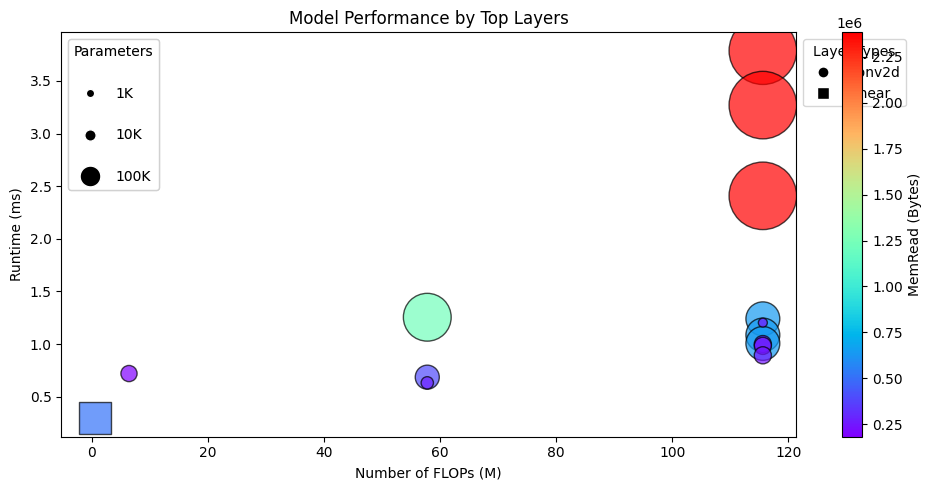

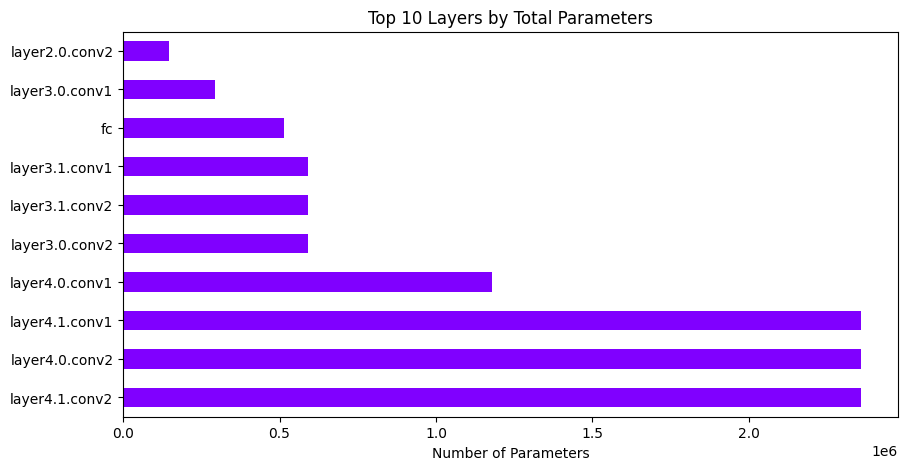

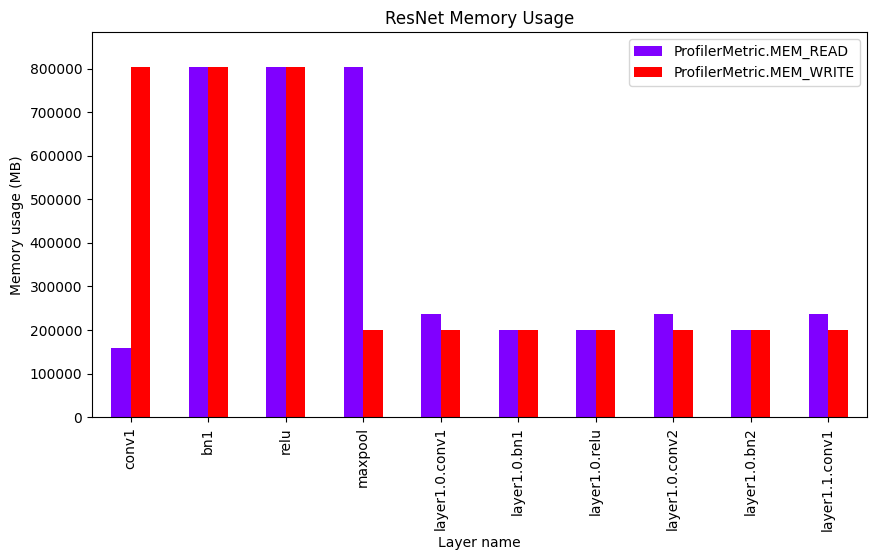

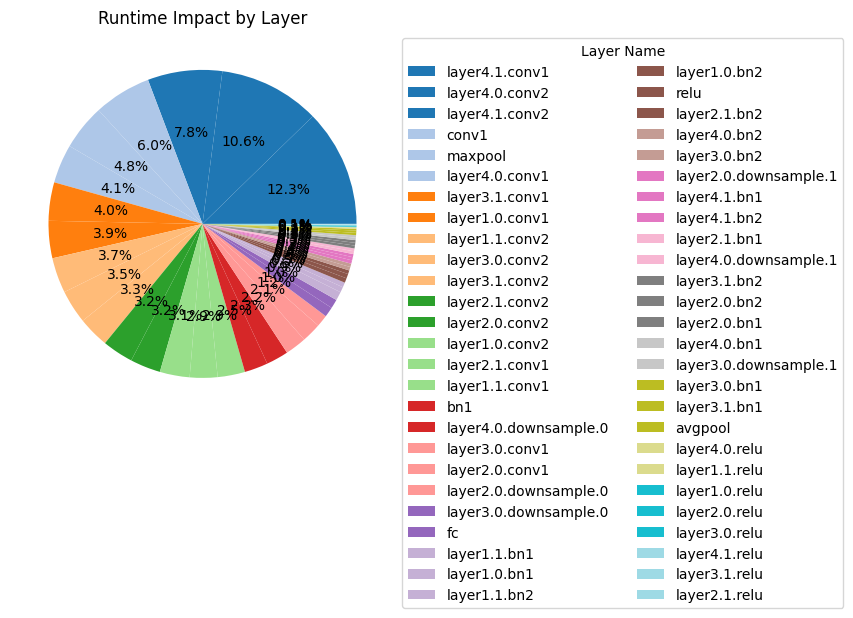

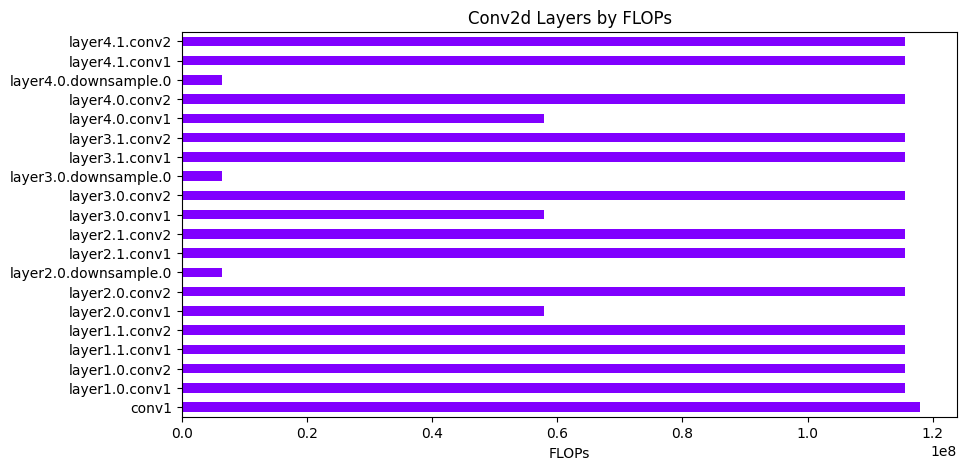

In [13]:
figsize = (10, 5)
analyzer.plot_top_n_layers(n=15, figsize=figsize, colormap="rainbow").show()
analyzer.plot_total_params_per_layer(
    figsize=figsize, colormap="rainbow", limit=10
).show()
analyzer.plot_memory_usage(figsize=figsize, colormap="rainbow").show()
analyzer.plot_layer_wise_impact(
    ProfilerMetric.RUNTIME, figsize=figsize, colormap="tab20"
).show()
analyzer.plot_layers_by_type(
    "Conv2d", metric=ProfilerMetric.FLOPS, figsize=figsize, colormap="rainbow"
).show()